In [6]:
import torch
import triton
from torch.utils.cpp_extension import load

BLOCK_SIZE = 32
device = torch.device("cuda")

cuda_module = load(
    name="naive_matmul",
    extra_include_paths=["cuda"],
    sources=["cuda/naive_cuda_matmul.cpp", "cuda/naive_cuda_matmul.cu"])

In [7]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    cuda_module.torch_launch_naive_cuda_matmul(out, a, b, M, N, K, a.stride(0),
                                               a.stride(1), b.stride(0),
                                               b.stride(1), out.stride(0),
                                               out.stride(1), BLOCK_SIZE)
    torch.cuda.synchronize()
    return out

In [8]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    assert torch.allclose(torch.matmul(a, b), matmul(a, b), atol=5e-4), size

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['cuda', 'torch'],
                             line_names=[
                                 "CUDA",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="naive-cuda-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'cuda':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

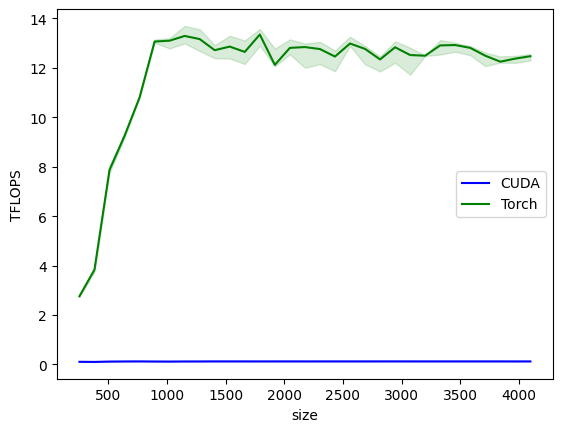

naive-cuda-matmul-perf:
      size      CUDA      Torch
0    256.0  0.107222   2.759410
1    384.0  0.102419   3.834176
2    512.0  0.116610   7.869239
3    640.0  0.121618   9.248659
4    768.0  0.124000  10.801813
5    896.0  0.119225  13.065300
6   1024.0  0.116963  13.099524
7   1152.0  0.121170  13.291346
8   1280.0  0.121766  13.164466
9   1408.0  0.123913  12.715512
10  1536.0  0.123692  12.860849
11  1664.0  0.123667  12.645582
12  1792.0  0.123232  13.348484
13  1920.0  0.123858  12.121332
14  2048.0  0.123941  12.809174
15  2176.0  0.123388  12.841381
16  2304.0  0.123568  12.760935
17  2432.0  0.123946  12.457880
18  2560.0  0.123628  12.984819
19  2688.0  0.123730  12.768176
20  2816.0  0.124192  12.341316
21  2944.0  0.124247  12.833279
22  3072.0  0.123878  12.518839
23  3200.0  0.123528  12.492452
24  3328.0  0.123745  12.909076
25  3456.0  0.123783  12.923456
26  3584.0  0.124076  12.809201
27  3712.0  0.124062  12.492048
28  3840.0  0.123816  12.251119
29  3968.0  0.12

In [10]:
benchmark.run(show_plots=True, print_data=True)

In [11]:
torch.cuda.empty_cache()